In [1]:
from data_transformations import mnist_transform
import torchvision.transforms as transforms
from data_loaders import mnist_dataloader
from loss_funcs import CrossEntropyLoss
from models import VGG11, ConvNet
from trainers import Trainer, MPTrainer
from testers import Tester
import numpy as np

import matplotlib.pyplot as plt
from loggers import set_logger

In [2]:
set_logger(data_name='mnist', save_path='./loggers/log')

In [3]:
def tile_image(image):
    '''duplicate along channel axis'''
    return image.repeat(3,1,1)

In [4]:
transform=[
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: tile_image(x))
        ]

In [5]:
train_dataset, test_dataset = mnist_dataloader.get_dataset(
    './datasets', transform=mnist_transform(lst_trans_operations=transform))

print('Train data set:', len(train_dataset))
print('Test data set:', len(test_dataset))

Train data set: 60000
Test data set: 10000


In [6]:
train_dataloader, valid_dataloader, test_dataloader = mnist_dataloader.loader(
    train_dataset, test_dataset)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([128, 3, 32, 32])
Labels batch shape: torch.Size([128])


In [7]:
test_features, test_labels = next(iter(test_dataloader))
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {test_labels.size()}")

Feature batch shape: torch.Size([1, 3, 32, 32])
Labels batch shape: torch.Size([1])


In [8]:
loss_func = CrossEntropyLoss()

In [9]:
# model = VGG11(n_classes=10).cuda()
# model
model = ConvNet(out_channels=10).cuda()
model

ConvNet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [10]:
print("Total number of parameters =", np.sum(
    [np.prod(parameter.shape) for parameter in model.parameters()]))

Total number of parameters = 6474


In [11]:
trainer = Trainer(model, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader,
                  train_epochs=20, valid_epochs=2, learning_rate=0.001, loss_func=loss_func, optimization_method='Adam')

In [12]:
trainer.load_model('saved_models/convnet_mnist.model')

ConvNet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [13]:
import torch
import time

from models import LRPModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
def plot_relevance_scores(
    x: torch.tensor, r: torch.tensor, name: str,) -> None:
    """Plots results from layer-wise relevance propagation next to original image.
    Method currently accepts only a batch size of one.
    Args:
        x: Original image.
        r: Relevance scores for original image.
        name: Image name.
    """
    max_fig_size = 20

    _, _, img_height, img_width = x.shape
    max_dim = max(img_height, img_width)
    fig_height, fig_width = (
        max_fig_size * img_height / max_dim,
        max_fig_size * img_width / max_dim,
    )

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(fig_width, fig_height))

    x = x[0].squeeze().permute(1, 2, 0).detach().cpu()
    x_min = x.min()
    x_max = x.max()
    x = (x - x_min) / (x_max - x_min)
    axes[0].imshow(x)
    axes[0].set_axis_off()

    r_min = r.min()
    r_max = r.max()
    r = (r - r_min) / (r_max - r_min)
    axes[1].imshow(r, cmap="afmhot")
    axes[1].set_axis_off()

    fig.tight_layout()
    plt.show()

In [15]:
lrp_model = LRPModel(model=model, top_k=0.02)

torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 8, 8])
torch.Size([1, 32, 1, 1])
torch.Size([1, 32])
torch.Size([1, 32])
torch.Size([1, 32])
torch.Size([1, 10])
torch.Size([1, 32])
torch.Size([1, 32])
torch.Size([1, 32])
torch.Size([1, 32, 8, 8])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 16, 16, 16])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 3, 32, 32])
1.06 FPS


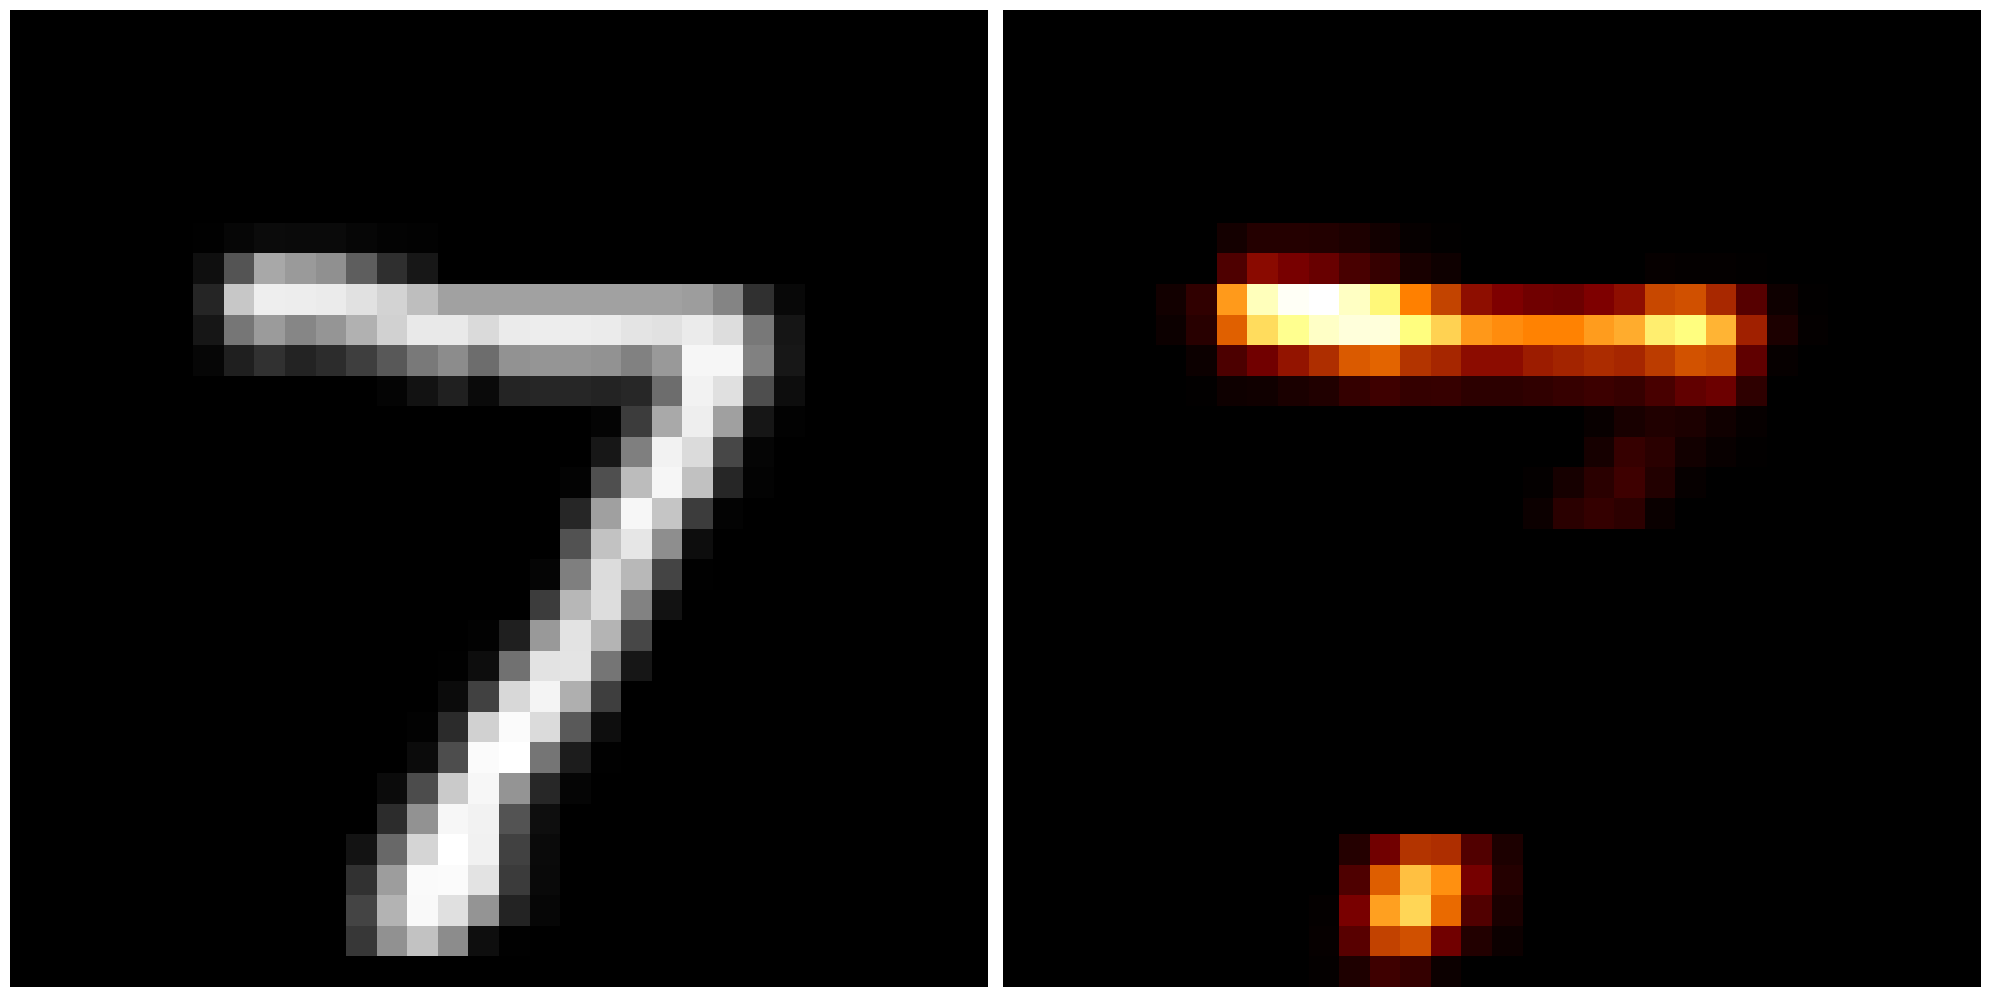

torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 8, 8])
torch.Size([1, 32, 1, 1])
torch.Size([1, 32])
torch.Size([1, 32])
torch.Size([1, 32])
torch.Size([1, 10])
torch.Size([1, 32])
torch.Size([1, 32])
torch.Size([1, 32])
torch.Size([1, 32, 8, 8])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 16, 16, 16])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 3, 32, 32])
181.46 FPS


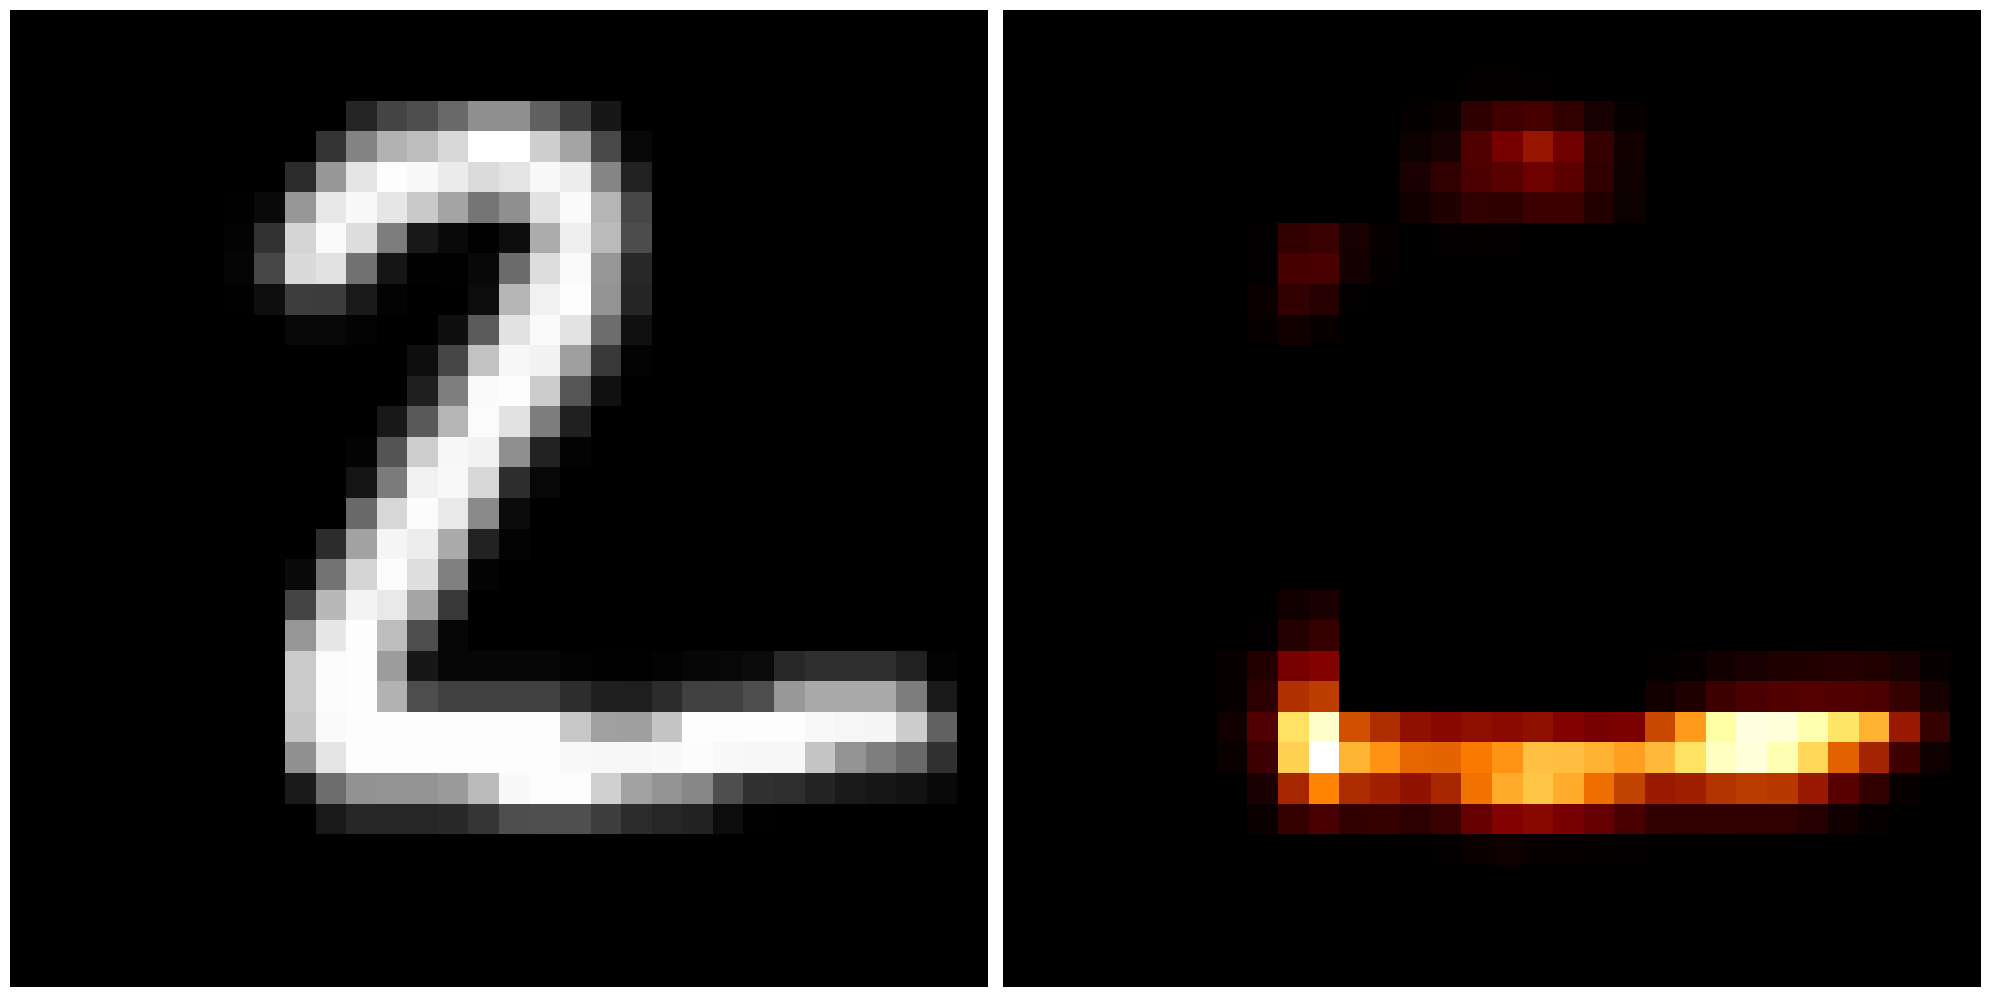

torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 8, 8])
torch.Size([1, 32, 1, 1])
torch.Size([1, 32])
torch.Size([1, 32])
torch.Size([1, 32])
torch.Size([1, 10])
torch.Size([1, 32])
torch.Size([1, 32])
torch.Size([1, 32])
torch.Size([1, 32, 8, 8])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 16, 16, 16])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 3, 32, 32])
252.61 FPS


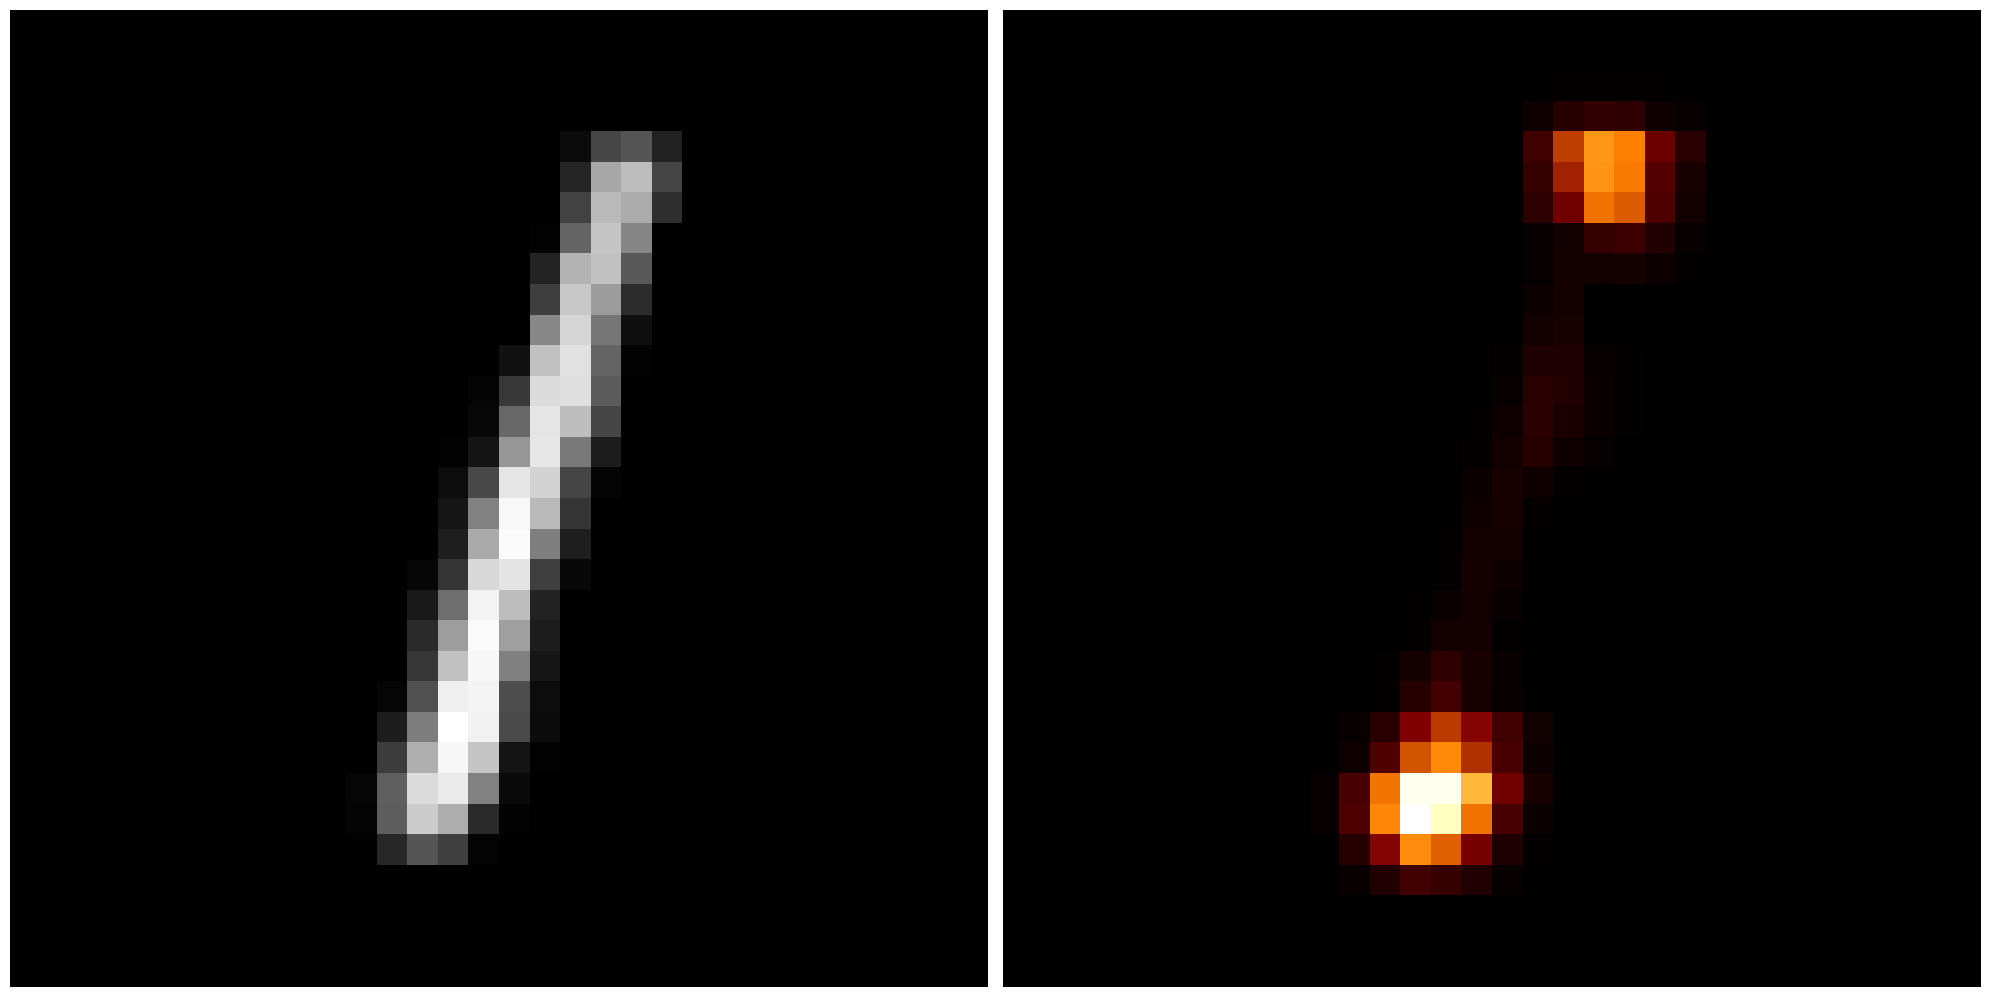

torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 8, 8])
torch.Size([1, 32, 1, 1])
torch.Size([1, 32])
torch.Size([1, 32])
torch.Size([1, 32])
torch.Size([1, 10])
torch.Size([1, 32])
torch.Size([1, 32])
torch.Size([1, 32])
torch.Size([1, 32, 8, 8])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 16, 16, 16])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 3, 32, 32])
251.73 FPS


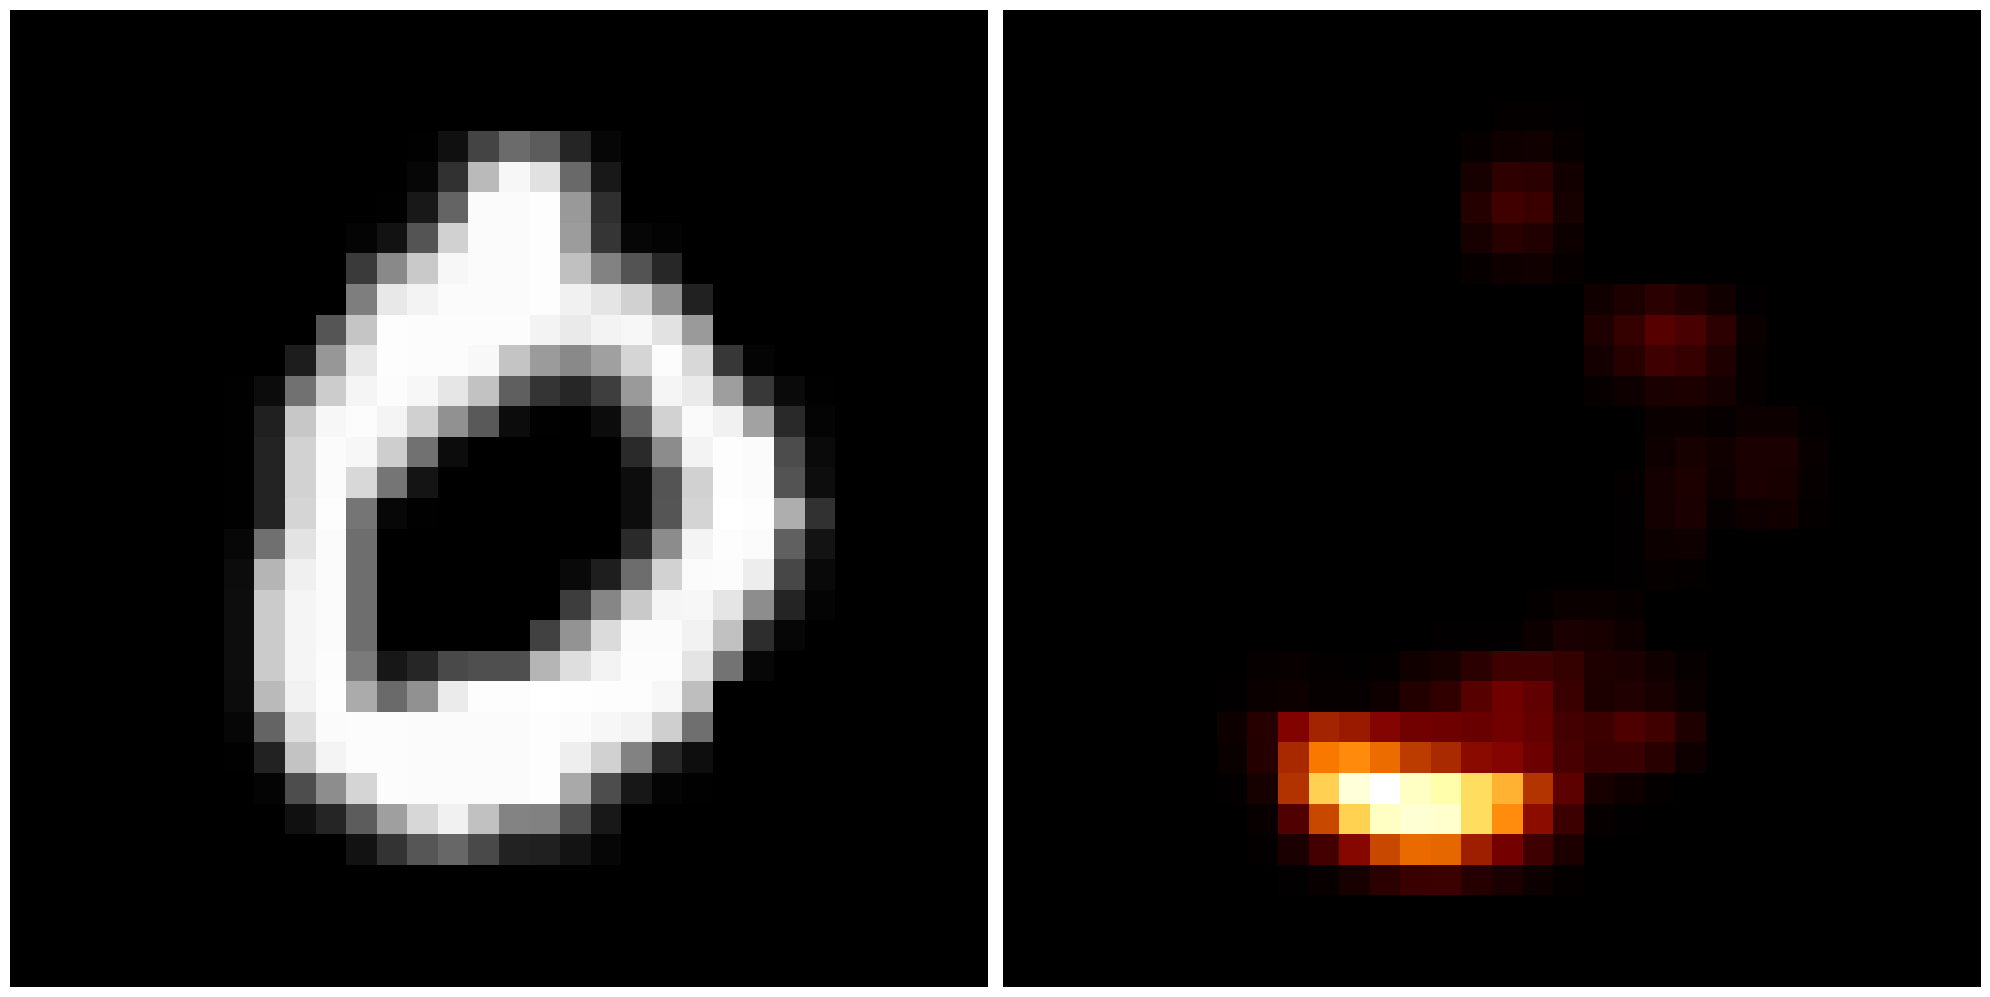

torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 8, 8])
torch.Size([1, 32, 1, 1])
torch.Size([1, 32])
torch.Size([1, 32])
torch.Size([1, 32])
torch.Size([1, 10])
torch.Size([1, 32])
torch.Size([1, 32])
torch.Size([1, 32])
torch.Size([1, 32, 8, 8])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 16, 16, 16])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 3, 32, 32])
235.87 FPS


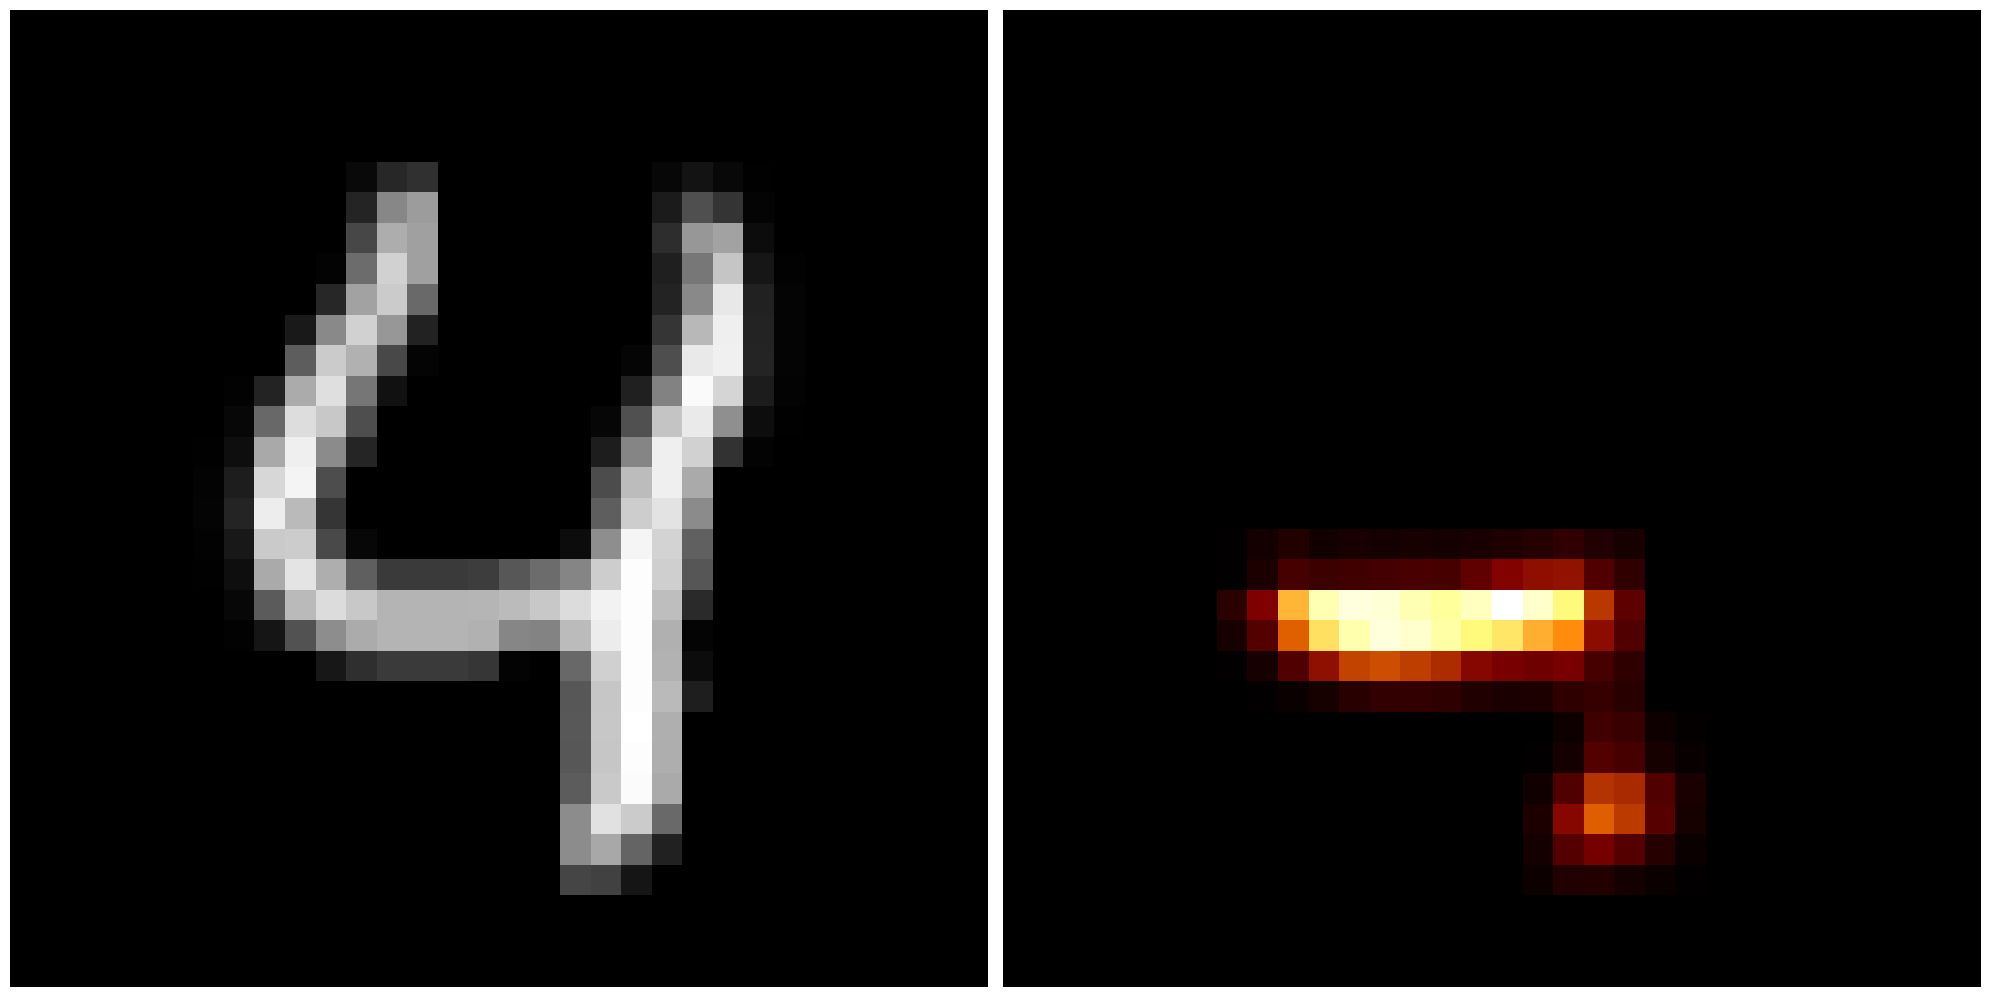

In [16]:
for i, (x, y) in enumerate(test_dataloader):
    if i == 5:
        break
    x = x.to(device)
    # y = y.to(device)  # here not used as method is unsupervised.
    t0 = time.time()
    r = lrp_model.forward(x)
    print("{time:.2f} FPS".format(time=(1.0 / (time.time() - t0))))
    plot_relevance_scores(x=x, r=r, name=str(i))